# Krafthack March 7-8 2022
**Team: Data Liberators**  
- Andris Piebalgs
- Hayden Hohns
- Simon Stavland

# Importing python libraries

In [37]:
import os
import time

from dataclasses import dataclass
from functools import wraps
from typing import Any, Callable

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler

%matplotlib inline

## Loading dataset

In [18]:
# datasets are stored in the data folder
data_dir = os.path.join("..","data")
dataset_1 = os.path.join(data_dir,"input_dataset-1.parquet")
dataset_2 = os.path.join(data_dir,"input_dataset-2.parquet")
bolt_pretension_file = os.path.join("bolt_pretension.csv")
prediction_input_file = os.path.join(data_dir,"prediction_input.parquet")

# validation data
validation_raw = pd.read_parquet(prediction_input_file)
training_data_1 = pd.read_parquet(dataset_1)
training_data_2 = pd.read_parquet(dataset_2)

# features are found from the validation set
feature_names = list(validation_raw.columns)

# dataset 2 contains the training data:
x_raw = training_data_2[feature_names]
target_vars = training_data_2.filter(regex="Tensile")


# Preprocessing and feature engineering

In [22]:
# functions for preprocessing pipeline

def log_df_pipe(f: Callable):
    """
    Decorator for logging functions handling dataframes
    Can be applied to functions where a dataframe is the input and output
    Typically functions used with df.pipe(f, *args)
    """
    @wraps(f)
    def wrapper(df, *args, **kwargs):
        start = time.time()
        result = f(df, *args, **kwargs)
        elapsed_time = time.time() - start
        print(f"{f.__name__} took {elapsed_time} seconds")
        print(f"Dataframe shape: {result.shape}")
        print(f"NA in dataframe: {result.isna().sum().sum()}")
        return result

    return wrapper

@log_df_pipe
def copy_df(df:pd.DataFrame):
    return df.copy()

@log_df_pipe
def mode_to_numerical(df: pd.DataFrame):
    df.loc[:, "mode"] = (df["mode"]=="operation").astype(float)
    return df

@log_df_pipe
def drop_na(df: pd.DataFrame):
    return df.dropna(axis=0)


@log_df_pipe
def add_seasonality_features(df: pd.DataFrame) -> pd.DataFrame:
    """Perform pre-processing of data.

    Args:
        df (pd.DataFrame): Dataframe that contains a valid index (datetime).

    Returns:
        pd.DataFrame: Same input dataframe but with extra columns.
    """
    df["month"] = df.index.month
    df["day"] = df.index.day
    # heavy rain: september-november, snow: december-march, melting: april-june, dry: july-august
    # Snow = 1, Melting = 2, Dry = 3, Rain = 4
    seasons = {
        1: 1, 2: 1, 3: 1, 
        4: 2, 5: 2, 6: 2,
        7: 3, 8: 3,
        9: 4, 10: 4, 11: 4,
        12: 1
    }
    df["season"] = df["month"].map(seasons)
    return df

In [23]:
x = (
    x_raw.pipe(copy_df)
    .pipe(mode_to_numerical)
    .pipe(add_seasonality_features)
    .pipe(drop_na)
)

validation = (
    validation_raw.pipe(copy_df)
    .pipe(mode_to_numerical)
    .pipe(add_seasonality_features)
    .pipe(drop_na)
)

copy_df took 0.05825400352478027 seconds
Dataframe shape: (1874087, 7)
NA in dataframe: 744522
mode_to_numerical took 0.10825777053833008 seconds
Dataframe shape: (1874087, 7)
NA in dataframe: 744522
add_seasonality_features took 0.14457011222839355 seconds
Dataframe shape: (1874087, 10)
NA in dataframe: 744522
drop_na took 0.25466012954711914 seconds
Dataframe shape: (1750000, 10)
NA in dataframe: 0
copy_df took 0.00234222412109375 seconds
Dataframe shape: (226364, 7)
NA in dataframe: 0
mode_to_numerical took 0.013981819152832031 seconds
Dataframe shape: (226364, 7)
NA in dataframe: 0
add_seasonality_features took 0.0163421630859375 seconds
Dataframe shape: (226364, 10)
NA in dataframe: 0
drop_na took 0.05258321762084961 seconds
Dataframe shape: (226364, 10)
NA in dataframe: 0


### Ensure that nans are removed for target variables too

In [25]:
# Drop nans in target data
def drop_target_nans(targets_df, train_raw_df):
    is_nan_row = train_raw_df.isna().any(axis=1)
    targets_df = targets_df[~is_nan_row]
    return targets_df

In [28]:
targets_df = (
    target_vars.pipe(copy_df)
    .pipe(drop_target_nans, x_raw )
)

copy_df took 0.05074620246887207 seconds
Dataframe shape: (1874087, 6)
NA in dataframe: 744522


In [31]:
assert targets_df.shape[0] == x.shape[0]

# Build ML model

In [51]:
# container for model response
@dataclass
class ModelResponse:
    bolt_name: str
    model: Any
    scaler: Any
    train_mape: float
    test_mape: float
    y_test: Any
    y_pred: Any

# Baseline model

In [64]:
def train_linear_bolts_models(train_df, targets_df):
    
    res = {}
    for target_name, target_data in targets_df.iteritems():
        X_train, X_test, y_train, y_test = train_test_split(train_df, target_data, test_size = 0.4)
        
        # scale training data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        # train regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Make predictions and calculate metrics
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
        test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

        # save to output dict
        res[target_name] = ModelResponse(bolt_name=target_name, model = model, scaler=scaler, train_mape=train_mape, test_mape=test_mape, y_test=y_test, y_pred=y_pred_test)

        print(f"finished training {target_name}")
    return res
        

In [65]:
linear_res = train_linear_bolts_models(x, targets_df)

finished training Bolt_1_Tensile
finished training Bolt_2_Tensile
finished training Bolt_3_Tensile
finished training Bolt_4_Tensile
finished training Bolt_5_Tensile
finished training Bolt_6_Tensile


In [73]:
for response in linear_res.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

train mape: 0.0003919099350238153, test mape: 0.00039225697137085556
train mape: 0.0004123787448502117, test mape: 0.00041299373446455044
train mape: 0.00027554781169530923, test mape: 0.0002754183199162816
train mape: 0.000300321533925371, test mape: 0.00030082498994232797
train mape: 0.00031577024809109893, test mape: 0.0003145418465709871
train mape: 0.00042260915041108995, test mape: 0.0004230343965192224


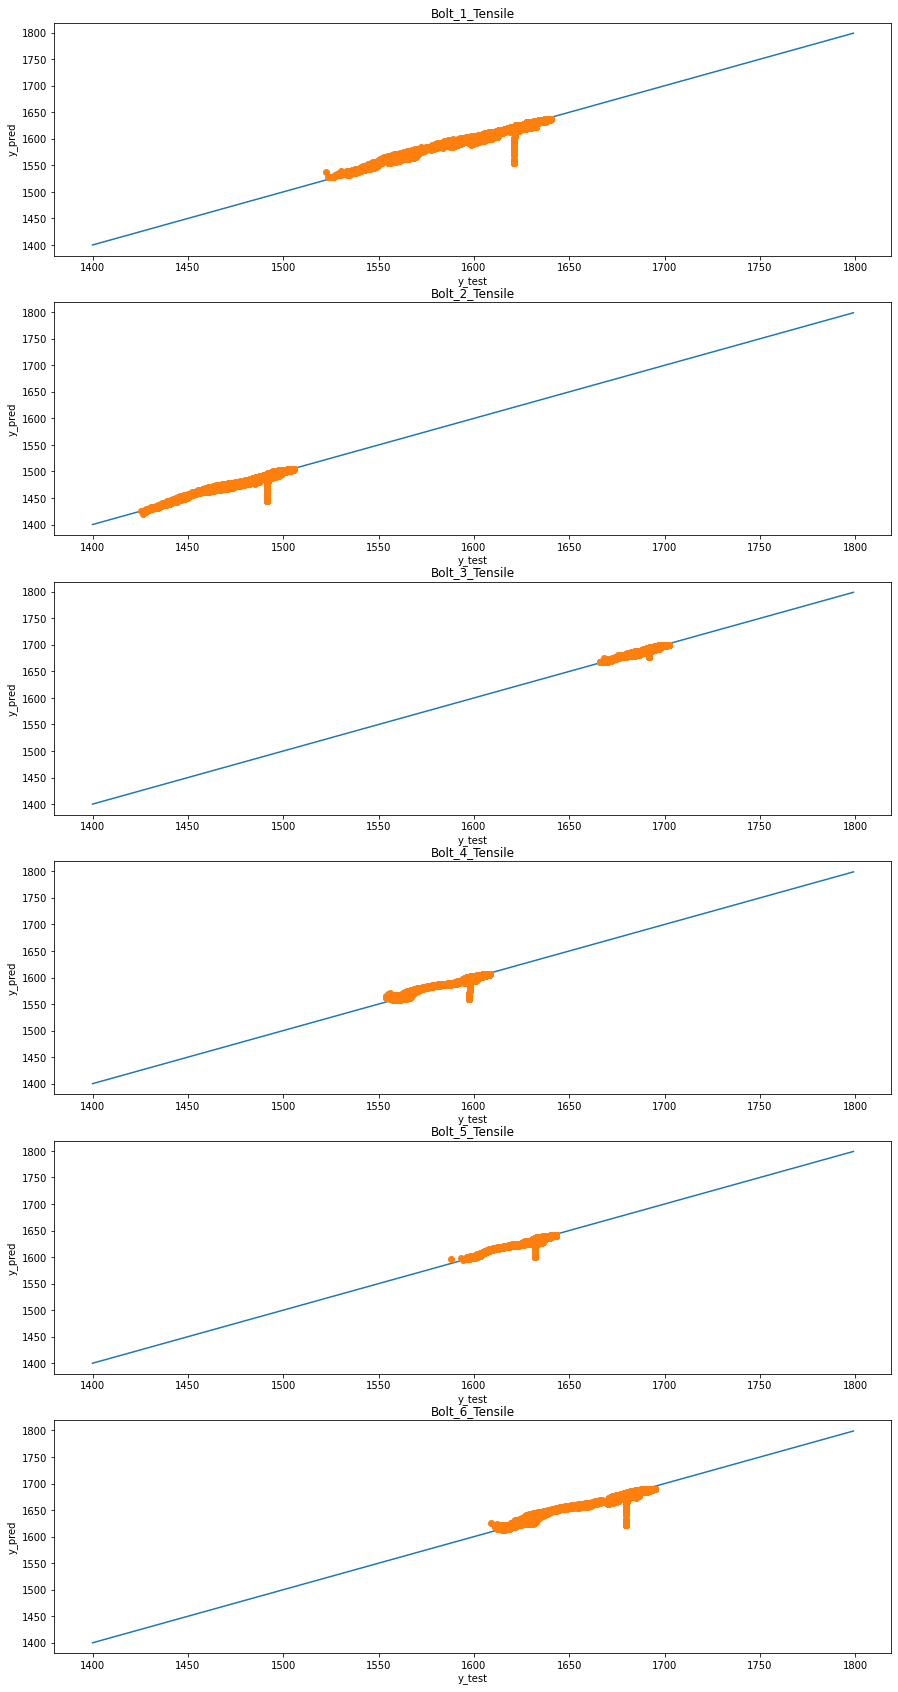

In [66]:
fig, axs = plt.subplots(6, figsize=(15, 30))
for i, model_response in enumerate(linear_res.values()):
    y_test = model_response.y_test
    y_pred = model_response.y_pred
    axs[i].plot(range(1400,1800), range(1400, 1800))
    axs[i].plot(y_test, y_pred, "o")
    axs[i].set_title(model_response.bolt_name)
    axs[i].set(xlabel="y_test", ylabel="y_pred")

# ML Model

In [71]:
# TODO: add hyperparameter tuning with cros validation

def train_non_linear_bolts_models(train_df, targets_df):
    
    res = {}
    for target_name, target_data in targets_df.iteritems():
        X_train, X_test, y_train, y_test = train_test_split(train_df, target_data, test_size = 0.4, shuffle=True)
        
        # scale training data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        # train regression model
        model = RandomForestRegressor(n_estimators=8)
        model.fit(X_train, y_train)
        
        # Make predictions and calculate metrics
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
        test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

        # save to output dict
        res[target_name] = ModelResponse(bolt_name=target_name, model = model, scaler=scaler, train_mape=train_mape, test_mape=test_mape, y_test=y_test, y_pred=y_pred_test)

        print(f"finished training {target_name}")
    return res
        

In [44]:
scoring = {'mean_absolute_percentage_error': make_scorer(mean_absolute_percentage_error)}
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('clf', model)])


scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring)
print(scores)

NameError: name 'model' is not defined

In [72]:
res = train_non_linear_bolts_models(x, targets_df)

finished training Bolt_1_Tensile
finished training Bolt_2_Tensile
finished training Bolt_3_Tensile
finished training Bolt_4_Tensile
finished training Bolt_5_Tensile
finished training Bolt_6_Tensile


In [74]:
for response in res.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

train mape: 3.940473956102417e-06, test mape: 9.663580700842417e-06
train mape: 4.659791893041756e-06, test mape: 1.1408333462552677e-05
train mape: 2.747323151459976e-06, test mape: 6.71669459463751e-06
train mape: 3.484937933580939e-06, test mape: 8.551255394308542e-06
train mape: 4.028810431149774e-06, test mape: 9.926683591708245e-06
train mape: 5.646151227812098e-06, test mape: 1.3749427591416405e-05


# Visual data validation

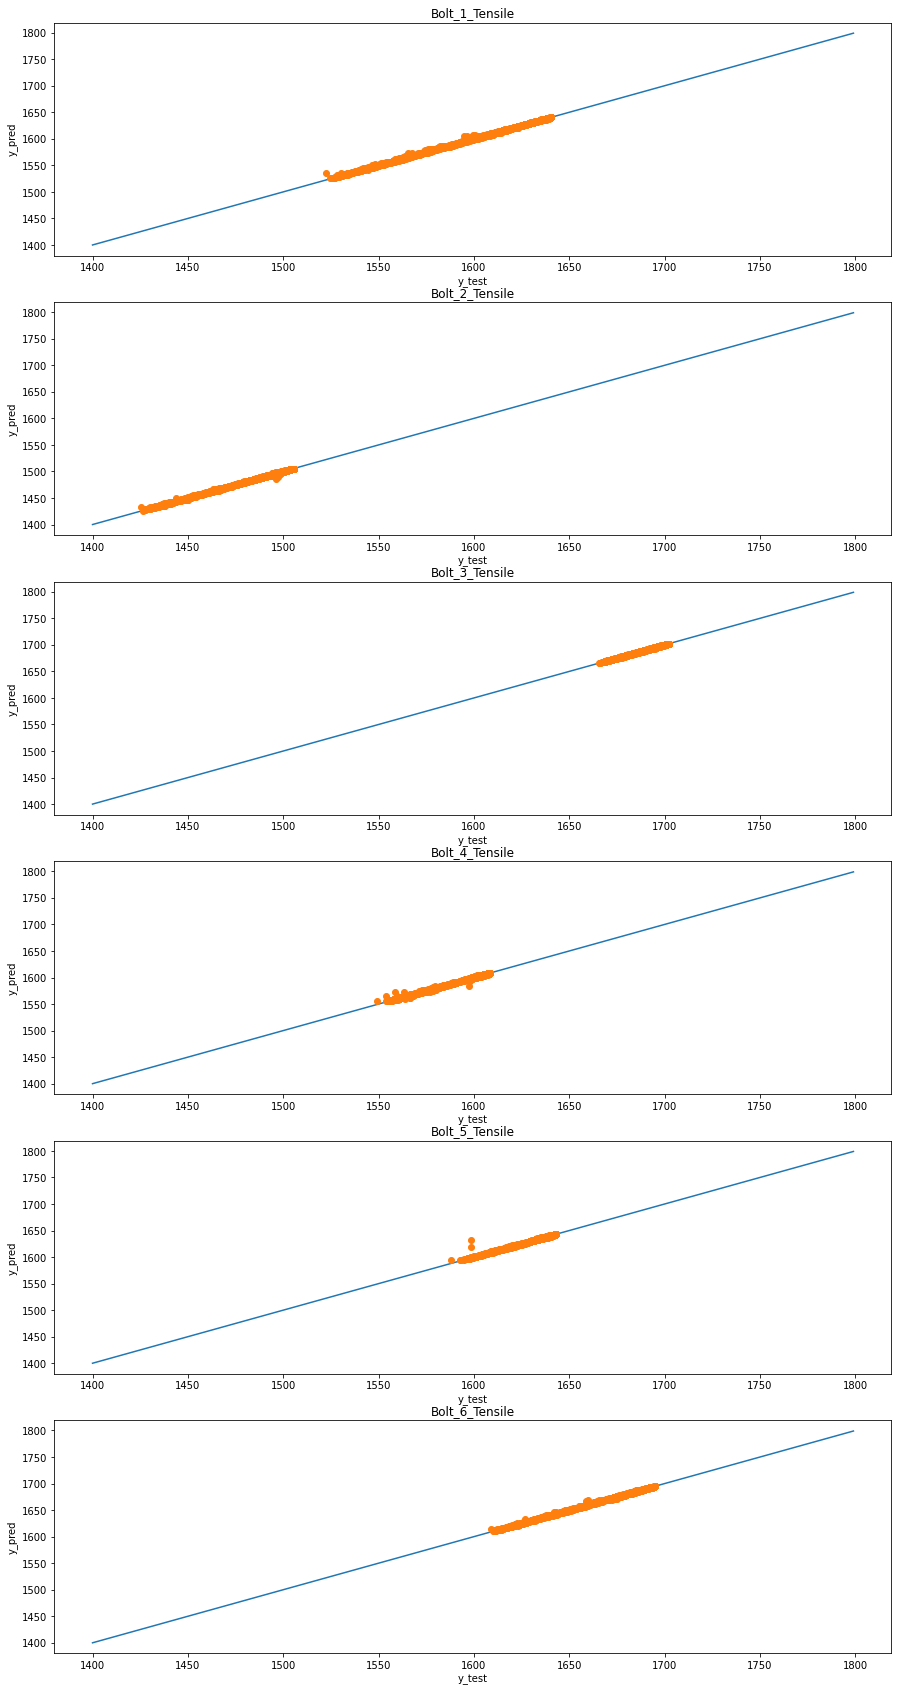

In [75]:
fig, axs = plt.subplots(6, figsize=(15, 30))
for i, model_response in enumerate(res.values()):
    y_test = model_response.y_test
    y_pred = model_response.y_pred
    axs[i].plot(range(1400,1800), range(1400, 1800))
    axs[i].plot(y_test, y_pred, "o")
    axs[i].set_title(model_response.bolt_name)
    axs[i].set(xlabel="y_test", ylabel="y_pred")

# Export csv file with predictions

In [76]:
def create_predictions_df(validation_data: pd.DataFrame, model_responses):
    predictions = []
    timestamps = validation_data.index
    for model_response in model_responses.values():
        validation_data_scaled = model_response.scaler.transform(validation_data)
        y_hat = model_response.model.predict(validation_data_scaled)
        y_hat_series = pd.Series(name=model_response.bolt_name, index=timestamps, data=y_hat)
        predictions.append(y_hat_series)
    
    return pd.concat(predictions, axis=1)

csv_export_filename = "bolt_tensile_predictions.csv"
predictions_df = create_predictions_df(validation, res)
predictions_df.to_csv(csv_export_filename)

# Visually investigate predictions

In [84]:
# TODO: further improve below visualisations

[Text(0.5, 0, 'Unit 4 power'), Text(0, 0.5, 'Bolt 1 tensile')]

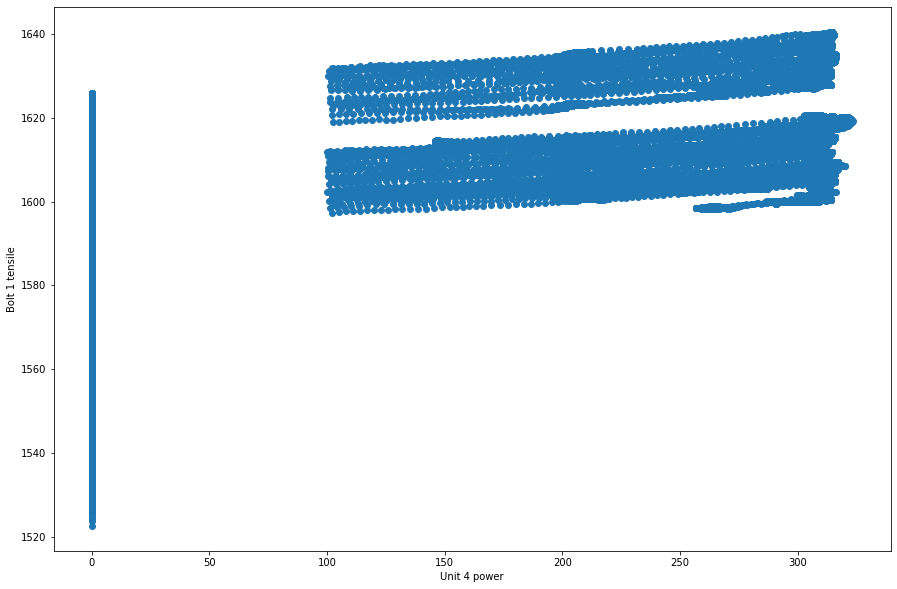

In [81]:
# Compare bolt tension with power in training dataset
fig, axs = plt.subplots(1, figsize=(15, 10))
axs.scatter(x["Unit_4_Power"].values, targets_df["Bolt_1_Tensile"].values)
axs.set(xlabel="Unit 4 power", ylabel="Bolt 1 tensile")


In [ ]:
# Compare predictd bolt tension with power in training dataset

[Text(0.5, 0, 'Unit 4 power'), Text(0, 0.5, 'Bolt 1 tensile')]

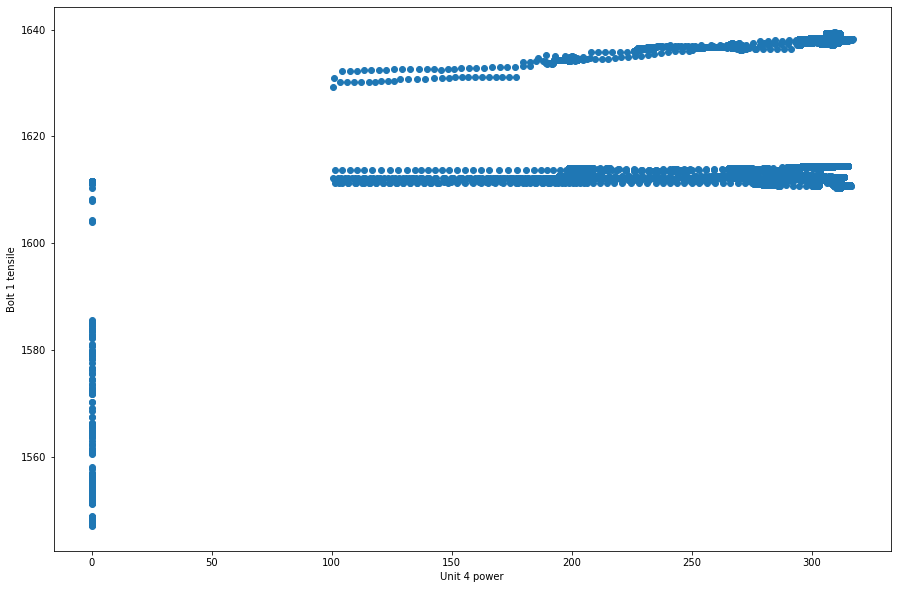

In [83]:
fig, axs = plt.subplots(1, figsize=(15, 10))
axs.scatter(validation["Unit_4_Power"], predictions_df["Bolt_1_Tensile"])
axs.set(xlabel="Unit 4 power", ylabel="Bolt 1 tensile")